In [ ]:
!pip install deap
!pip install pmdarima

In [3]:
import os
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, grangercausalitytests
from sklearn.preprocessing import StandardScaler, RobustScaler
from io import StringIO
from deap import base, creator, tools, algorithms
from statsmodels.tsa.api import VAR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.stats import shapiro, probplot
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import PowerTransformer
import random 
from elitism import eaSimpleWithElitism
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from joblib import Parallel, delayed
import pmdarima as pm

In [4]:
df = pd.read_csv('./covid_data/CONVENIENT_us_deaths.csv', skiprows=1)
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
daily_deaths = df.drop(columns=['Date']).sum(axis=1)
df = pd.DataFrame({
    'Date': df['Date'],
    'Deaths': daily_deaths
})
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y', errors='coerce')
df = df[(df['Date'] >= '2022-01-01') & (df['Date'] <= '2022-12-31')]
df = df.sort_values(by="Date").set_index("Date")

## Exploratory Data Analysis

In [5]:
df.head()

,Deaths
Date,
2022-01-01,402.0
2022-01-02,459.0
2022-01-03,1905.0
2022-01-04,2323.0
2022-01-05,2225.0


In [6]:
df.tail()

,Deaths
Date,
2022-12-27,356.0
2022-12-28,990.0
2022-12-29,924.0
2022-12-30,216.0
2022-12-31,26.0


In [7]:
df.describe()

,Deaths
count,365.000000
mean,732.317808
std,847.477617
min,-253.000000
25%,184.000000
50%,470.000000
75%,873.000000
max,4129.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2022-01-01 to 2022-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Deaths  365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [9]:
df.isnull().sum()

Deaths    0
dtype: int64

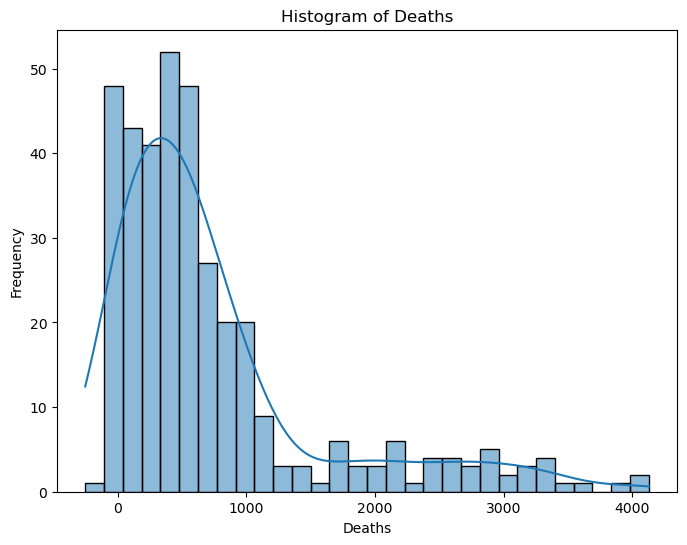

In [10]:
plt.figure(figsize=(8, 6))  # Set the figure size
sns.histplot(df['Deaths'], kde=True, bins=30)  # Plot histogram with KDE
plt.title(f'Histogram of Deaths')  # Add a title
plt.xlabel("Deaths")  # Label the x-axis
plt.ylabel('Frequency')  # Label the y-axis
plt.show()  # Display the plot

In [11]:
def check_stationary(data):
    column = data.columns[0]
    series = data[column].dropna()
    if series.empty:
        print(f"Skipping {column}: Series is empty after dropping NaN values.")
        return
    # Check if the series is constant
    if series.nunique() == 1:
        print(f"Skipping {column}: Series is constant")
        return
    # Perform ADF test
    result = adfuller(series)
    print(f"ADF Statistic for {column}: {result[0]}")
    print(f"p-value for {column}: {result[1]}")
    if result[1] > 0.05:
        print(f"{column} is non-stationary")
    else:
        print(f"{column} is stationary")
    print("\n\n")

In [12]:
def check_correlation (data):
    print("\nPlotting ACF and PACF...")
    plot_acf(data, lags=30, title="ACF of Deaths")
    plt.show()
    
    plot_pacf(data, lags=36, title="PACF of Deaths")
    plt.show()

### Testing for Stationarity

In [13]:
check_stationary(df[['Deaths']])

ADF Statistic for Deaths: -1.9546388627302662
p-value for Deaths: 0.3068094492994907
Deaths is non-stationary





### Testing Correlation


Plotting ACF and PACF...


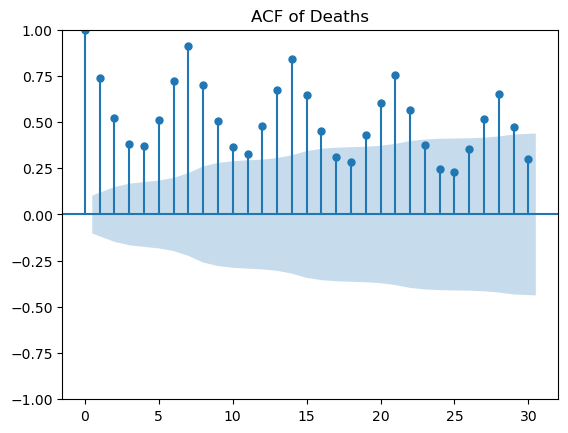

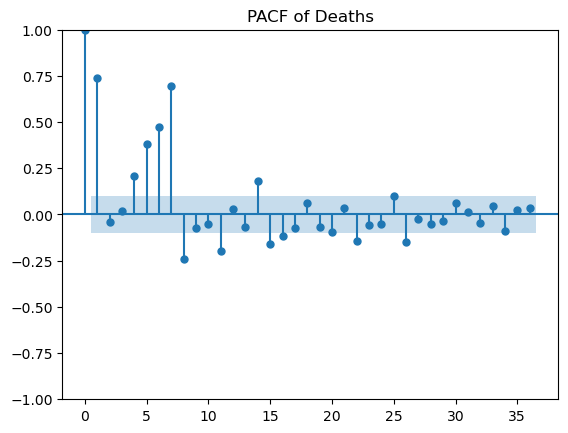

In [14]:
check_correlation(df[['Deaths']])

### Analyze trend

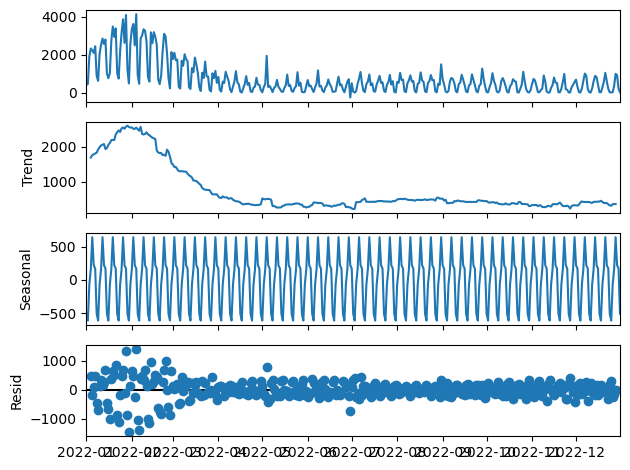

In [15]:
result = seasonal_decompose(df, model='additive', period=7)
result.plot()
plt.show()

## Preprocessing

### Scaling and Normalization

In [16]:
rScaler = RobustScaler()
df['Deaths'] = rScaler.fit_transform(df[['Deaths']])
#transformer = PowerTransformer(method='yeo-johnson')
#df['Deaths'] = transformer.fit_transform(df[['Deaths']])

ADF Statistic for Deaths: -27.766519495620038
p-value for Deaths: 0.0
Deaths is stationary




Plotting ACF and PACF...


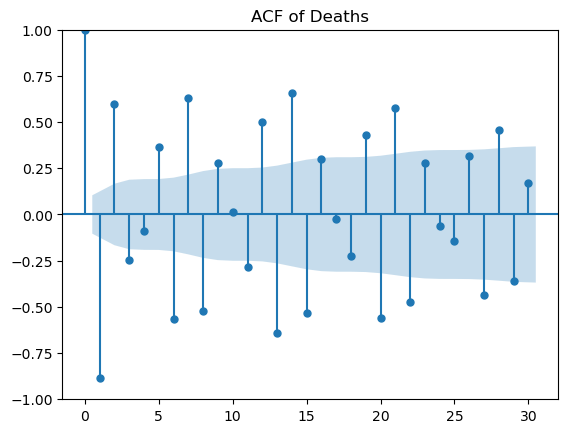

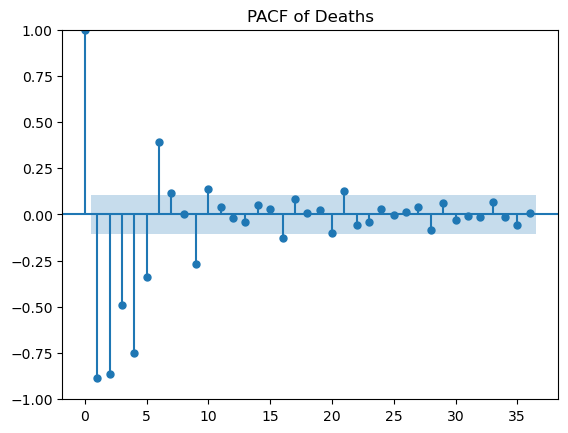

In [19]:
df = df.diff().diff().diff().diff().dropna()
check_stationary(df[['Deaths']])
check_correlation(df[['Deaths']])

In [121]:
df = df.reset_index()
split_date = df['Date'].max() - pd.Timedelta(weeks=8)
train = df[df['Date'] <= split_date]
test = df[df['Date'] > split_date]

train = train.set_index("Date")
test = test.set_index("Date")

train.index = pd.DatetimeIndex(train.index).to_period('D')
test.index = pd.DatetimeIndex(test.index).to_period('D')

# ExponentialSmoothing

### Genetic Algorithm for Hyperprameter Tuning

In [122]:
def evaluate(individual):
    alpha, beta, gamma, seasonal_periods = individual  
    seasonal_periods = int(seasonal_periods)

    if (seasonal_periods < 14 or 
        gamma < 0.8 or gamma > 0.9 or  # Gamma ∈ [0,1]
        alpha < 0.0 or alpha > 0.1 or  # Alpha ∈ [0,1]
        beta < 1.0 or beta > 1.1       # Beta ∈ [0,1]
    ):
        return (float('inf'),) 

    tscv = TimeSeriesSplit(n_splits=3)  # 3 splits (adjust based on data size)
    
    sse_scores = []

    for train_index, test_index in tscv.split(train):
        train_fold, test_fold = train.iloc[train_index], train.iloc[test_index]
        
        model = ExponentialSmoothing(
            train_fold['Deaths'],
            trend='add', 
            seasonal='add', 
            seasonal_periods=seasonal_periods
        ).fit(
            smoothing_level=alpha, 
            smoothing_trend=beta, 
            smoothing_seasonal=gamma, 
            optimized=False
        )
        
        pred = model.forecast(len(test_fold))
        sse= mean_squared_error(test_fold['Deaths'], pred)
        sse_scores.append(sse)

    return (np.mean(sse_scores),) 
def mutate_gaussian(individual,  mu=0, sigma=0.1, indpb=0.3):
    tools.mutGaussian(individual, mu=mu, sigma=sigma, indpb=indpb)
    # Ensure values remain within valid ranges
    return individual,

In [123]:
pop_size = 200
cx_pd = 0.8
mut_pb = 0.2
gen = 100
random.seed(42)
np.random.seed(42)
toolbox = base.Toolbox()
toolbox.register("attr_alpha", lambda: random.choice([0.0, 0.1]))
toolbox.register("attr_beta", lambda: random.choice([1.0, 1.1]))
toolbox.register("attr_gamma", lambda: random.choice([0.8, 0.9]))
toolbox.register("attr_seasonal", lambda: random.choice([14, 15]))   # For seasonal periods, adjust range based on your data
if hasattr(creator, "FitnessMin"):
    del creator.FitnessMin  # Remove previous FitnessMin class

if hasattr(creator, "Individual"):
    del creator.Individual  # Remove previous Individual class

creator.create("FitnessMin", base.Fitness, weights=(-1.0, ))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_alpha, toolbox.attr_beta, toolbox.attr_gamma, toolbox.attr_seasonal), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxUniform, indpb=0.5)  # Blend crossover
toolbox.register("mutate", mutate_gaussian)
toolbox.register("select", tools.selTournament, tournsize=5) # Tournament selection

In [124]:
def run_ga():
    pop = toolbox.population(n=pop_size)  # Initial population of 100
    hof = tools.HallOfFame(1)  # Keep track of the best solution
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    result, log = eaSimpleWithElitism(pop, toolbox, cxpb=cx_pd, mutpb=mut_pb, ngen=gen, stats=stats, halloffame=hof, verbose=True)

    best_individual = hof[0]  # Return best hyperparameters

    plt.plot(log.select('min'), color='red')
    plt.plot(log.select('avg'), color='green')
    plt.xlabel('generations')
    plt.ylabel('min/avg per generation')
    plt.show()
    
    print(f"Best hyperparameters: {best_individual}")
    print(f"Best SSE: {best_individual.fitness.values}")
    return best_individual

## Training

gen	nevals	min     
0  	200   	0.346115
1  	168   	0.346115
2  	153   	0.346115
3  	163   	0.346115
4  	178   	0.346115
5  	168   	0.346115
6  	160   	0.346115
7  	163   	0.346115
8  	165   	0.346114
9  	157   	0.346114
10 	169   	0.346114
11 	164   	0.346114
12 	177   	0.346114
13 	166   	0.340788
14 	159   	0.340788
15 	164   	0.340788
16 	170   	0.340756
17 	161   	0.340709
18 	164   	0.340709
19 	163   	0.340709
20 	178   	0.340709
21 	147   	0.340709
22 	176   	0.340701
23 	168   	0.340701
24 	170   	0.340701
25 	177   	0.340692
26 	168   	0.340682
27 	154   	0.340472
28 	155   	0.340472
29 	166   	0.340472
30 	162   	0.340472
31 	164   	0.340472
32 	171   	0.340472
33 	166   	0.340472
34 	166   	0.340471
35 	166   	0.340471
36 	169   	0.340471
37 	161   	0.340471
38 	167   	0.340471
39 	170   	0.340471
40 	165   	0.340471
41 	167   	0.340471
42 	163   	0.340471
43 	169   	0.340471
44 	159   	0.340471
45 	162   	0.340471
46 	169   	0.340471
47 	166   	0.340471
48 	178   	0.340471


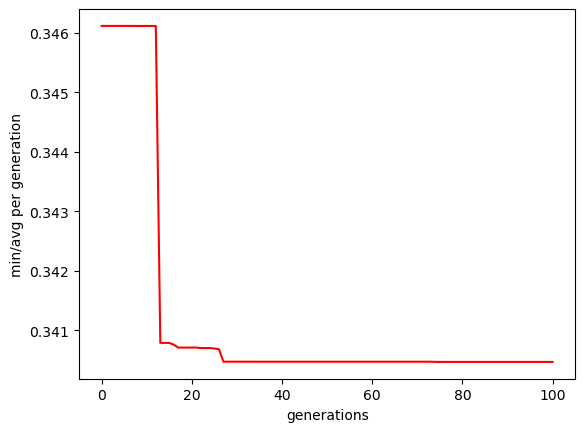

Best hyperparameters: [0.0029141253092629595, 1.0870880043552287, 0.8929602778710917, 14.299664005781953]
Best SSE: (0.3404677182251503,)
                       ExponentialSmoothing Model Results                       
Dep. Variable:                   Deaths   No. Observations:                  308
Model:             ExponentialSmoothing   SSE                            130.729
Optimized:                        False   AIC                           -227.948
Trend:                         Additive   BIC                           -160.806
Seasonal:                      Additive   AICC                          -225.021
Seasonal Periods:                    14   Date:                 Mon, 03 Feb 2025
Box-Cox:                          False   Time:                         00:32:10
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------

In [125]:
best_params = run_ga()  # This returns an Individual (list of alpha, beta)
alpha, beta, gamma, seasonal_periods = best_params
seasonal_periods = int(seasonal_periods)
model = ExponentialSmoothing(
        train['Deaths'],
        trend='add', 
        seasonal='add', 
        seasonal_periods=seasonal_periods
    ).fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma, optimized=False)

# Print results
print(model.summary())

## Prediction

In [126]:
forecast = model.forecast(steps=len(test))
deaths_pred = forecast # Predicted Deaths (scaled)
deaths_true = test["Deaths"]    
residuals = test['Deaths'] - forecast

In [127]:
mse = mean_squared_error(deaths_true, deaths_pred)
rmse = root_mean_squared_error(deaths_true, deaths_pred)
print(f"MSE for Deaths: {mse}")
print(f"Root MSE for Deaths: {rmse}")
residuals = deaths_true - deaths_pred

MSE for Deaths: 0.05795666306199205
Root MSE for Deaths: 0.24074190134247933


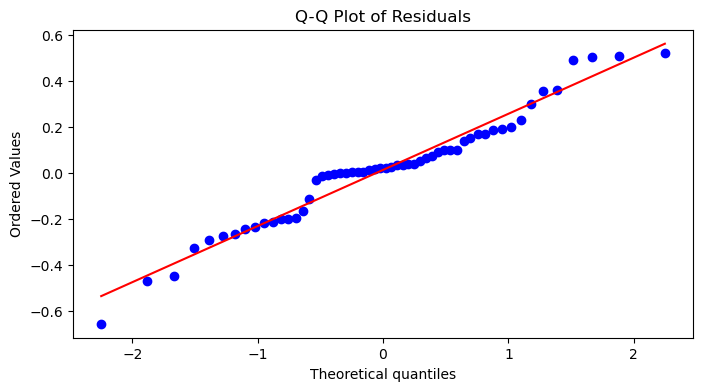

Shapiro-Wilk test p-value: 0.10671


In [128]:
plt.figure(figsize=(8, 4))
probplot(residuals, plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk test p-value: {shapiro_test.pvalue:.5f}")  # Should be > 0.05 for normality


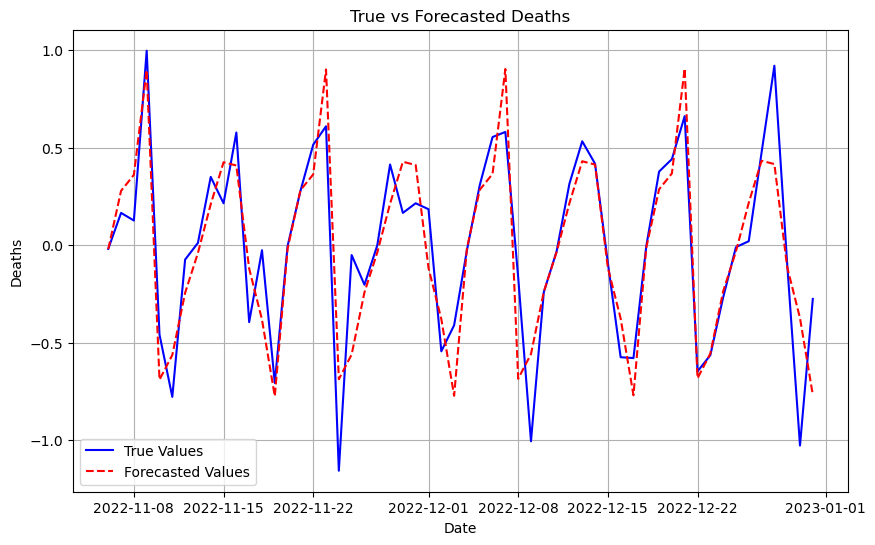

In [129]:
plt.figure(figsize=(10, 6))
plt.plot(test.index.to_timestamp(), test['Deaths'], label='True Values', color='blue')
plt.plot(test.index.to_timestamp(), forecast, label='Forecasted Values', linestyle='--', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.title('True vs Forecasted Deaths')
plt.grid()
plt.show()

# SARIMA

## Training

In [181]:
model = pm.auto_arima(train['Deaths'], 
                    seasonal=True, 
                    m=12,            # Seasonal period (annual cycle, since COVID waves often repeat yearly)
                    start_p=0,       # Initial AR order (autoregressive)
                    start_q=0,       # Initial MA order (moving average)
                    d=1,          # Let auto_arima determine differencing for trend stationarity
                    D=1,          # Let auto_arima determine seasonal differencing
                    max_p=3,         # Max AR terms (avoid overfitting)
                    max_q=3,         # Max MA terms
                    max_P=2,         # Max seasonal AR terms
                    max_Q=2,         # Max seasonal MA terms
                    trace=True,      # Print search progress
                    error_action="ignore",
                    suppress_warnings=True,
                    stepwise=True,   # Efficient stepwise search
                    information_criterion="bic",  # AIC for model selection
                    test="adf",      # Use Augmented Dickey-Fuller test to auto-detect `d`
                    with_intercept=True,  # Allow a drift term for trends
)
model.summary()

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(1,1,1)[12] intercept   : BIC=inf, Time=1.37 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : BIC=1230.005, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : BIC=1134.904, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : BIC=inf, Time=0.82 sec
 ARIMA(0,1,0)(0,1,0)[12]             : BIC=1224.319, Time=0.02 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : BIC=1211.776, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : BIC=1106.299, Time=0.42 sec
 ARIMA(1,1,0)(2,1,1)[12] intercept   : BIC=inf, Time=2.02 sec
 ARIMA(1,1,0)(1,1,1)[12] intercept   : BIC=inf, Time=0.73 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : BIC=1180.140, Time=0.28 sec
 ARIMA(2,1,0)(2,1,0)[12] intercept   : BIC=1069.010, Time=0.82 sec
 ARIMA(2,1,0)(1,1,0)[12] intercept   : BIC=1133.020, Time=0.39 sec
 ARIMA(2,1,0)(2,1,1)[12] intercept   : BIC=inf, Time=3.12 sec
 ARIMA(2,1,0)(1,1,1)[12] intercept   : BIC=inf, Time=1.59 sec
 ARIMA(3,1,0)(2,1,0)[12] intercept   : BIC=inf, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  308
Model:             SARIMAX(3, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -387.252
Date:                            Mon, 03 Feb 2025   AIC                            792.505
Time:                                    08:12:48   BIC                            825.688
Sample:                                01-02-2022   HQIC                           805.792
                                     - 11-05-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.001      0.247      0.805      -0.002       0.002
ar.L1         -0.9487      0.050    -18.874      0.000      -1.047      -0.850
ar.L2         -0.7916      0.054    -14.753      0.000      -0.897      -0.686
ar.L3         -0.3458      0.045     -7.606      0.000      -0.435      -0.257
ma.L1         -0.9468      0.053    -17.876      0.000      -1.051      -0.843
ar.S.L12      -0.2854      0.030     -9.363      0.000      -0.345      -0.226
ar.S.L24      -0.8476      0.021    -40.932      0.000      -0.888      -0.807
ma.S.L12      -0.8457      0.086     -9.847      0.000      -1.014      -0.677
sigma2         0.6530      0.063     10.447      0.000       0.530       0.776
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                13.23
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.11   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predict

In [182]:
forecast = model.predict(n_periods=len(test['Deaths']))
mse = mean_squared_error(test['Deaths'], forecast)
rmse = root_mean_squared_error(test['Deaths'], forecast)
print(f"MSE for Deaths: {mse}")
print(f"Root MSE for Deaths: {rmse}")
residuals = test['Deaths'] - forecast

MSE for Deaths: 0.1414251383474833
Root MSE for Deaths: 0.37606533787027396


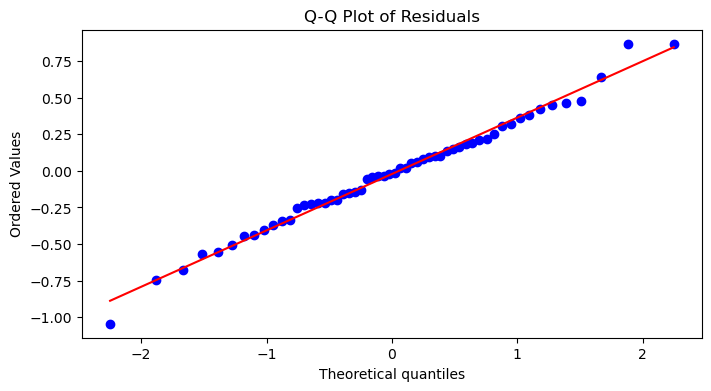

Shapiro-Wilk test p-value: 0.96600


In [183]:
plt.figure(figsize=(8, 4))
probplot(residuals, plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk test p-value: {shapiro_test.pvalue:.5f}")  # Should be > 0.05 for normality

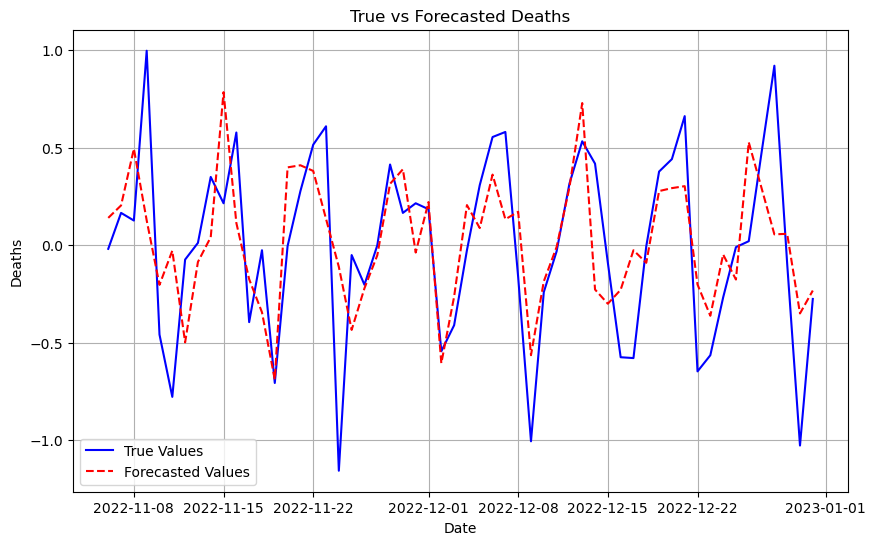

In [184]:
plt.figure(figsize=(10, 6))
plt.plot(test.index.to_timestamp(), test['Deaths'], label='True Values', color='blue')
plt.plot(test.index.to_timestamp(), forecast, label='Forecasted Values', linestyle='--', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.title('True vs Forecasted Deaths')
plt.grid()
plt.show()

In [ ]:
#